In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [2]:
NB_NODES = 50
DURATION = 10000   # Nb samples
REVOLUTION = 1800  # Nb samples
SAMPLE_FREQ = 0.1  # Hz, 1 sample every 10 seconds
CONNECTION_RANGE = 30000 # m

# Variables globales figures
TMAX = REVOLUTION/SAMPLE_FREQ
IDX = np.arange(0, TMAX, 1/SAMPLE_FREQ) # conversion en secondes

## 1. Formattage des données pour l'analyse
### 1.1 Importation du dataset

In [3]:
PATH = '..\..\data\cnes_swarm50\\track_'
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv')
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)

satellites[0]

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.428846e+05,-4.516533e+05,-4.604007e+05,-4.691266e+05,-4.778306e+05,-4.865122e+05,-4.951711e+05,-5.038068e+05,-5.124189e+05,-5.210071e+05,...,1.440812e+06,1.444147e+06,1.447475e+06,1.450795e+06,1.454108e+06,1.457413e+06,1.460711e+06,1.464001e+06,1.467284e+06,1.470559e+06
y,-7.388676e+05,-7.522884e+05,-7.656739e+05,-7.790237e+05,-7.923370e+05,-8.056132e+05,-8.188518e+05,-8.320520e+05,-8.452134e+05,-8.583352e+05,...,2.329204e+06,2.334225e+06,2.339233e+06,2.344229e+06,2.349213e+06,2.354185e+06,2.359145e+06,2.364092e+06,2.369028e+06,2.373951e+06
z,-2.011435e+06,-2.004528e+06,-1.997528e+06,-1.990435e+06,-1.983248e+06,-1.975968e+06,-1.968596e+06,-1.961132e+06,-1.953577e+06,-1.945930e+06,...,3.661057e+06,3.655167e+06,3.649258e+06,3.643331e+06,3.637384e+06,3.631419e+06,3.625435e+06,3.619433e+06,3.613412e+06,3.607372e+06


### 1.2 Conversion en objet Swarm (module swarm_sim)

In [4]:
swarm_data = {}

with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 1800/1800 [00:11<00:00, 155.60it/s]

Swarm of 50 node(s), connection range: 30000


### 1.3 Création de la topologie : établissement des ISL d'après la portée de connexion

In [5]:
neighbor_matrix_list = [swarm_data[t].neighbor_matrix() for t in range(REVOLUTION)]

In [7]:
with tqdm(total = REVOLUTION, desc = 'Removing expensive edges') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t].remove_expensive_edges()
        pbar.update(1)

Removing expensive edges: 100%|██████████| 1800/1800 [18:18<00:00,  1.64it/s]


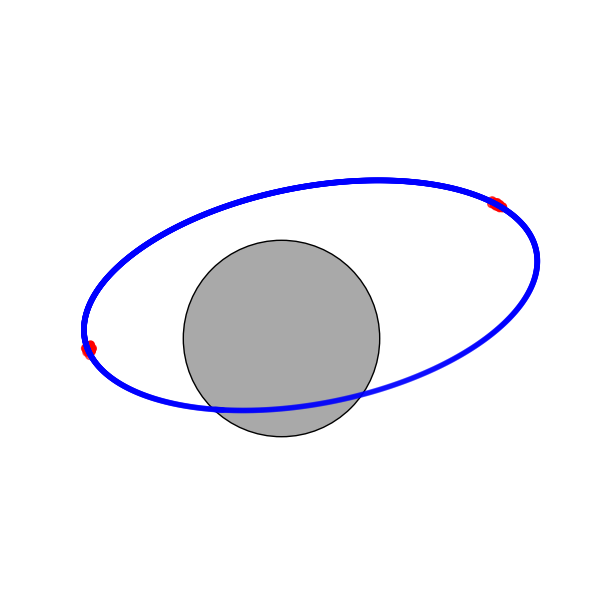

In [8]:
def plot_trajectory(nid, swarm_data, n_color='blue'):
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [sw.nodes[nid].x for sw in swarm_data.values()]
    y_data = [sw.nodes[nid].y for sw in swarm_data.values()]
    z_data = [sw.nodes[nid].z for sw in swarm_data.values()]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=10)
    ax.scatter(0,0,0, c='darkgray', edgecolor='black', s=20000)
    for t in (200,1100):
        ax.scatter([node.x for node in swarm_data[t].nodes], 
                   [node.y for node in swarm_data[t].nodes], 
                   [node.z for node in swarm_data[t].nodes], 
                   c='red', 
                   s=30)
    
plot_trajectory(0, swarm_data)

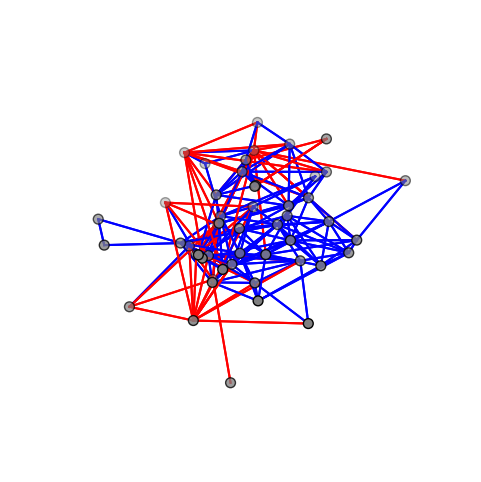

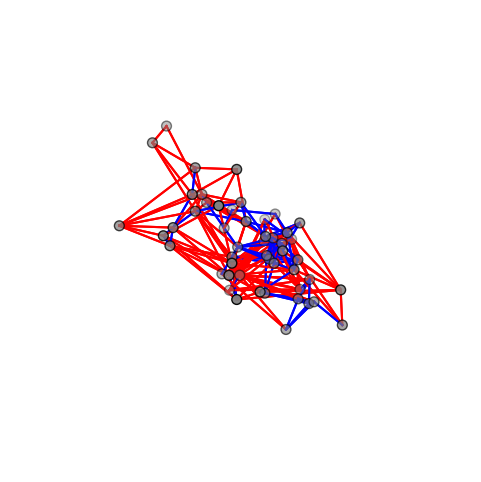

In [9]:
def plot_edges(swarm, n_color='gray', edgecolors=None):
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, edgecolor='black', s=50)
    if edgecolors==None:
        edgecolors = {1:'blue', 4:'red'}
    for n1 in swarm.nodes:
        for nid,w in n1.neighbors.items():
            n2 = swarm.get_node_by_id(nid)
            ax.plot([n1.x, n2.x], [n1.y, n2.y], [n1.z, n2.z], c=edgecolors[w])
                
plot_edges(swarm_data[200])
plot_edges(swarm_data[1100])

## 2. Propriétés du réseau

### 2.1 Mobilité
Vitesse de déplacement de l'essaim

In [11]:
def compute_velocity(sw1, sw2):
    return [n1.compute_dist(n2)*SAMPLE_FREQ for (n1,n2) in zip(sw1.nodes, sw2.nodes)]

swarm_velocity = [np.mean(compute_velocity(swarm_data[t], swarm_data[t+1])) for t in range(REVOLUTION-1)]
avg_swarm_velocity = np.mean(swarm_velocity)
print('Vitesse de déplacement moyenne de l\'essaim :', np.round(avg_swarm_velocity,2), 'm/s soit', np.round(avg_swarm_velocity*3.6,2), 'km/h')

Vitesse de déplacement moyenne de l'essaim : 1160.26 m/s soit 4176.95 km/h


In [12]:
# Distance par rapport à la Lune (pour comparaison)
def compute_moon_dist(sw):
    moon = Node(-1, x=0, y=0, z=0)
    return [moon.compute_dist(n) for n in sw.nodes]

moon_dist = [np.mean(compute_moon_dist(swarm_data[t])) for t in range(REVOLUTION)]
moon_dist_km = [e/1000 for e in moon_dist]

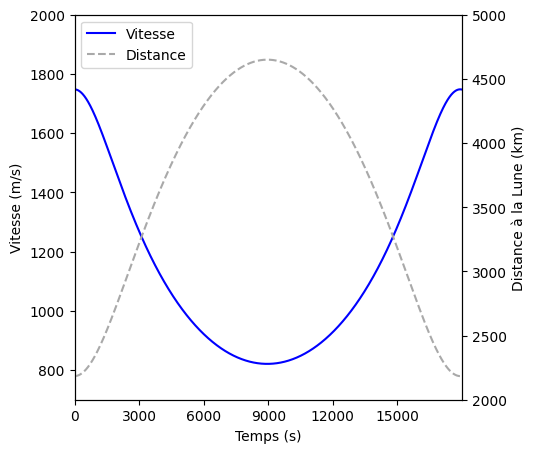

In [15]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX[:-1], swarm_velocity, c='blue', label='Vitesse')
#l2 = ax.hlines(avg_swarm_velocity, 0, TMAX, ls='--', color='red', label='Vitesse moyenne')
ax.set_xlim(0, TMAX)
ax.set_ylim(700,2000)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Vitesse (m/s)')
ax.set_xticks(np.arange(0, TMAX, 3000))

ax2 = ax.twinx()
l3 = ax2.plot(IDX, moon_dist_km, c='darkgray', ls='--', label='Distance')
ax2.set_ylim(2000,5000)
ax2.set_ylabel('Distance à la Lune (km)')

lns = l1 + l3
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')

Analyse des distances inter-satellites

In [16]:
def compute_distance_matrix(swarm_chunk):
    distance_matrix = {}
    with tqdm(total=REVOLUTION, desc='Computing Distance matrix') as pbar:
        for t in range(REVOLUTION):
            distance_matrix[t] = swarm_chunk[t].distance_matrix()
            pbar.update(1)
    return distance_matrix

dm = compute_distance_matrix(swarm_data)
avg_distances_time = [np.mean(dm_time) for dm_time in dm.values()]

Computing Distance matrix: 100%|██████████| 1800/1800 [00:02<00:00, 695.37it/s]


In [17]:
t1, t2, t3, t4 = 75, 460, 920, 1520

Text(0, 0.5, 'Distance (m)')

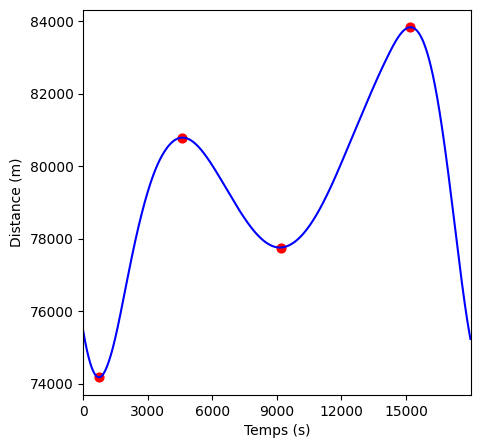

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX, avg_distances_time, c='blue', label='Inter-satellite')
ax.scatter([t1/SAMPLE_FREQ, t2/SAMPLE_FREQ, t3/SAMPLE_FREQ, t4/SAMPLE_FREQ], 
            [avg_distances_time[t1],
             avg_distances_time[t2],
             avg_distances_time[t3],
             avg_distances_time[t4]],
            c='red',
            s=40)
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 3000))
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Distance (m)')

In [19]:
np.mean(avg_distances_time)

79426.88622259893

### 2.2 Densité de noeuds
Degré (moyen et distribution)

In [21]:
degrees = [swarm_data[t].degree() for t in range(REVOLUTION)]
avg_degree_time = [np.mean(deg) for deg in degrees]

In [31]:
def degree_weighted(swarm): # Added to swarm_sim as a parameterizable function
    return [sum([1/weight for weight in node.neighbors.values()]) for node in swarm.nodes]

weighted_degree_list = [degree_weighted(swarm_data[t]) for t in range(REVOLUTION)]
avg_weighted_degree_time = [np.mean(deg) for deg in weighted_degree_list]

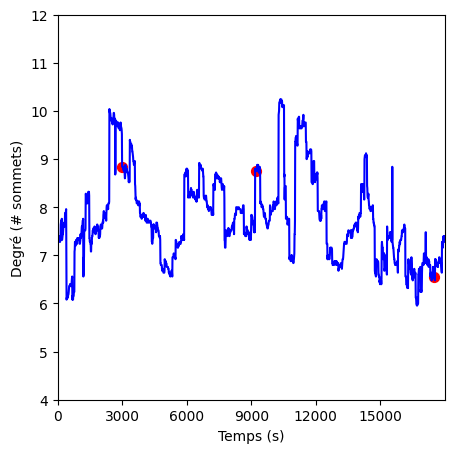

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(IDX, avg_degree_time, c='blue', label='Degré')
ax.scatter([t1/SAMPLE_FREQ, t2/SAMPLE_FREQ, t3/SAMPLE_FREQ], 
            [avg_degree_time[t1],
             avg_degree_time[t2],
             avg_degree_time[t3]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(4,12)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Degré (# sommets)')
ax.set_xticks(np.arange(0, TMAX, 3000))
#ax.legend()

In [47]:
t1, t2, t3 = 280,1085,1500

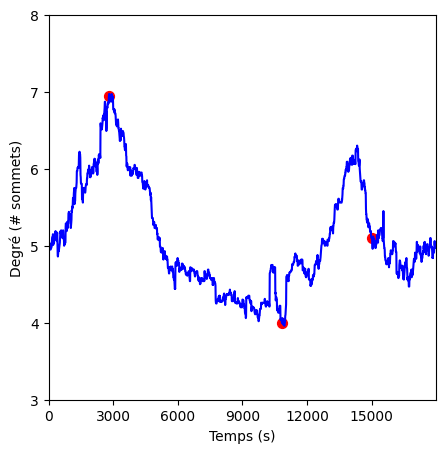

In [48]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(IDX, avg_weighted_degree_time, c='blue', label='Degré')
ax.scatter([t1/SAMPLE_FREQ, t2/SAMPLE_FREQ, t3/SAMPLE_FREQ], 
            [avg_weighted_degree_time[t1],
             avg_weighted_degree_time[t2],
             avg_weighted_degree_time[t3]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(3,8)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Degré (# sommets)')
ax.set_xticks(np.arange(0, TMAX, 3000))

Text(0, 0.5, 'Degree')

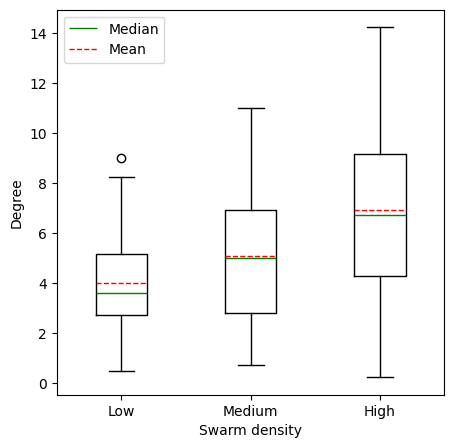

In [49]:
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([weighted_degree_list[t2],
                 weighted_degree_list[t3],
                 weighted_degree_list[t1]], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper left')
ax.set_xticklabels(['Low','Medium','High'])
ax.set_xlabel('Swarm density')
ax.set_ylabel('Degree')
#ax.set_ylim(0,320000)

Coefficient de clustering

In [ ]:
def node_cluster_coef(node):
    dv = len(node.neighbors)
    max_edges = dv*(dv-1)/2
    if max_edges == 0:
        return 0.0
    edges = 0.0
    for n1 in node.neighbors.keys():
        node1 = swarm.get_node_by_id(n1)
        for n2,w2 in node1.neighbors.items():
            if n2 in node.neighbors.keys():
                edges += 1/w2

In [16]:
coefs = [swarm_data[t].cluster_coef() for t in range(REVOLUTION)]
avg_coef_time = [np.mean(c) for c in coefs]

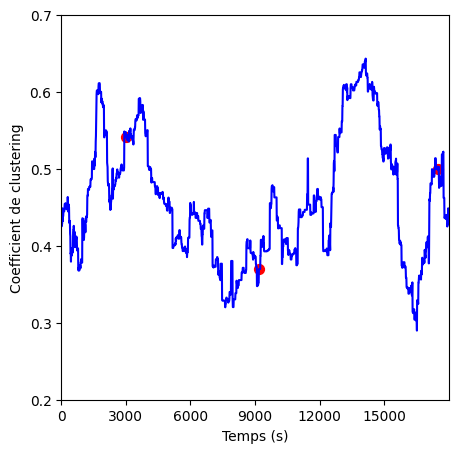

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX, avg_coef_time, c='blue', label='Clustering')
ax.scatter([t1/SAMPLE_FREQ, t2/SAMPLE_FREQ, t3/SAMPLE_FREQ], 
            [avg_coef_time[t1],
             avg_coef_time[t2],
             avg_coef_time[t3]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(0.2,0.7)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Coefficient de clustering')
ax.set_xticks(np.arange(0, TMAX, 3000))

(-0.05, 1.2)

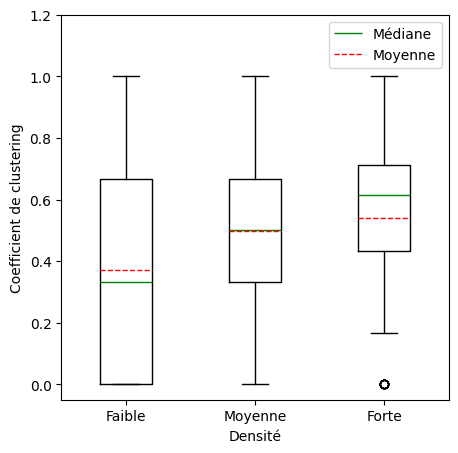

In [19]:
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([coefs[t2],
                 coefs[t3],
                 coefs[t1]], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper right')
ax.set_xticklabels(['Faible','Moyenne','Forte'])
ax.set_xlabel('Densité')
ax.set_ylabel('Coefficient de clustering')
ax.set_ylim(-0.05,1.2)

### 2.3 Disponibilité des ISL

Distribution des ICT

In [17]:
def pairwise_ict(nmat):
    total_contact = {}
    for n1 in range(NB_NODES):
        total_contact[n1] = [np.mean([nmat[t][n1][n2] for t in range(REVOLUTION)]) for n2 in range(NB_NODES)]
    ict = [[(1-n2)*100 for n2 in tc] for tc in total_contact.values()]
    return ict   

In [18]:
ict = pairwise_ict(nmat)
avg_ict_all = np.mean(ict)

In [19]:
existing_ict = [[e for e in row if e<100] for row in ict]
avg_ict_exist = np.mean([np.mean(row) for row in existing_ict])

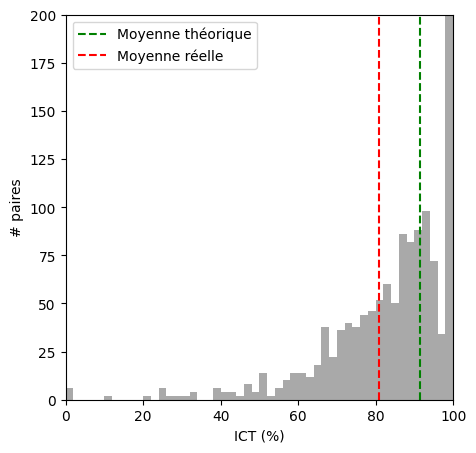

In [100]:
plt.figure(figsize=(5,5))
plt.hist([ e for row in ict for e in row], bins=50, color='darkgray')
plt.vlines(x=avg_ict_all, ymin=0, ymax=200, color='green', ls='--', label='Moyenne théorique')
plt.vlines(x=avg_ict_exist, ymin=0, ymax=200, color='red', ls='--', label='Moyenne réelle')

plt.xlabel('ICT (%)')
plt.ylabel('# paires')
plt.xlim(0,100)
plt.ylim(0,200)
plt.legend()

(-4.0, 104.0)

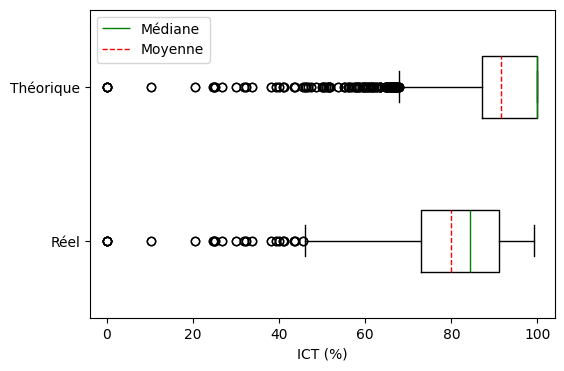

In [20]:
fig,ax = plt.subplots(figsize=(6,4))

bp = ax.boxplot([[e for row in existing_ict for e in row],
                 [e for row in ict for e in row]], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_yticklabels(['Réel','Théorique'])
#ax.set_xlabel('Essaim')
ax.set_xlabel('ICT (%)')
ax.set_xlim(-4,104)

Temps d'isolement

In [21]:
def isolation_time(degrees):
    iso = {}
    for nid in range(NB_NODES):
        degs = [degrees[t][nid] for t in range(REVOLUTION)]
        iso[nid] = len([e for e in degs if e==0])/REVOLUTION*100
    return iso

iso = isolation_time(degrees)

(-4.0, 104.0)

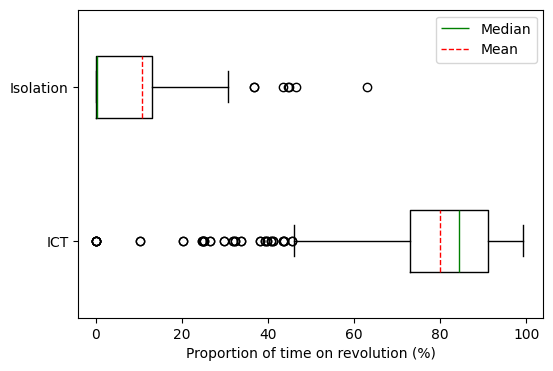

In [26]:
fig,ax = plt.subplots(figsize=(6,4))

bp = ax.boxplot([[e for row in existing_ict for e in row],
                 list(iso.values())], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right')
ax.set_yticklabels(['ICT','Isolation'])
#ax.set_xlabel('Essaim')
ax.set_xlabel('Proportion of time on revolution (%)')
ax.set_xlim(-4,104)

Composantes connexes

In [143]:
nb_cc = [len(swarm_data[t].connected_components()) for t in range(REVOLUTION)]
nb_iso = [len([cc for cc in swarm_data[t].connected_components() if len(cc)==1]) for t in range(REVOLUTION)]

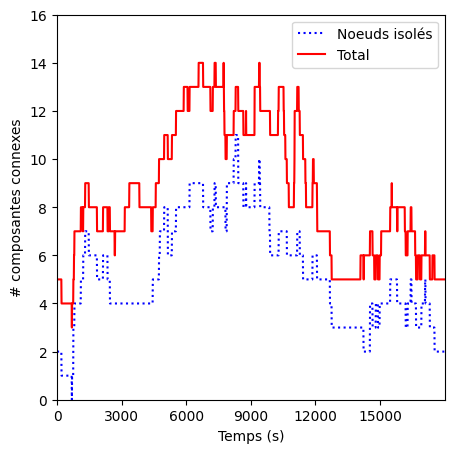

In [149]:
plt.figure(figsize=(5,5))
plt.plot(IDX, nb_iso, c='blue', ls=':', label='Noeuds isolés')
plt.plot(IDX, nb_cc, c='red', label='Total')
plt.xlabel('Temps (s)')
plt.ylabel('# composantes connexes')
plt.xlim(0,TMAX)
plt.ylim(0,16)
plt.xticks(np.arange(0, TMAX, 3000))
plt.legend()